In [1]:
#load libs
import keras.models

import os
import bregnn.io as io


Using TensorFlow backend.


In [2]:
# ## Read test data and model
# load data
base_dir = '/scratch/snx3000/musella/bregression'
data = io.read_data(base_dir+'/ttbar_unweighted_full80M_selected_test.hd5', columns = None )

# list all model files in the training folder
#target = '/users/musella/jupyter/bregression/hybrid_cfg'
target='/users/nchernya/HHbbgg_ETH/bregression/notebooks/HybdridLoss/'
models = get_ipython().getoutput('ls -t $target/*.hdf5')
models

# read training configuration
import json
with open('%s/config.json' % target) as fin:
    config = json.loads(fin.read())
config

# ## Compute predictions

features = config['options']['features'].split(',')

X = data[features].values
y = (data['Jet_mcPt']/data['Jet_pt']).values.reshape(-1,1)
y_hbb = (data['Jet_mcPt']/data['Jet_pt_reg']).values.reshape(-1,1)


Opening /scratch/snx3000/musella/bregression/ttbar_unweighted_full80M_selected_test.hd5 in read-only mode


In [3]:
model = keras.models.load_model(models[0],compile=False)

y_pred = model.predict(X)

# *Note*: the target is typically normalized in the training y = (y-mu)/sigma
# ## Convert raw prediction into actual scale and resolution estimation


if y_pred.shape[1] == 1: # with one output we only have a scale correction
    corr = y_pred
    res = None
elif y_pred.shape[1] == 2: # with two outputs first is mean and second is sigma
    corr = y_pred[:,0]
    res = y_pred[:,1]
elif y_pred.shape[1] == 3: # assume that 3 outputs are mean + 2 quantile
    corr = y_pred[:,0]
    res = 0.5*(y_pred[:,2] - y_pred[:,1])

# normalize back to energy scale
if config['options']['normalize_target']:
    corr *= config['y_std']
    corr += config['y_mean']

    if res is not None:
        res *= config['y_std']

# errors vector
if y_pred.shape[1] > 1:
    err = y[:,0]-corr
else:
    err = y-corr

# ## Characterize the outcome

print(y.mean(),y.std())


1.07361 0.270127


test me  0.0172262  std  0.201691  norm std  0.738941034501  norm mse  0.550017032507  norm mae  0.351097532773


TypeError: zip argument #2 must support iteration

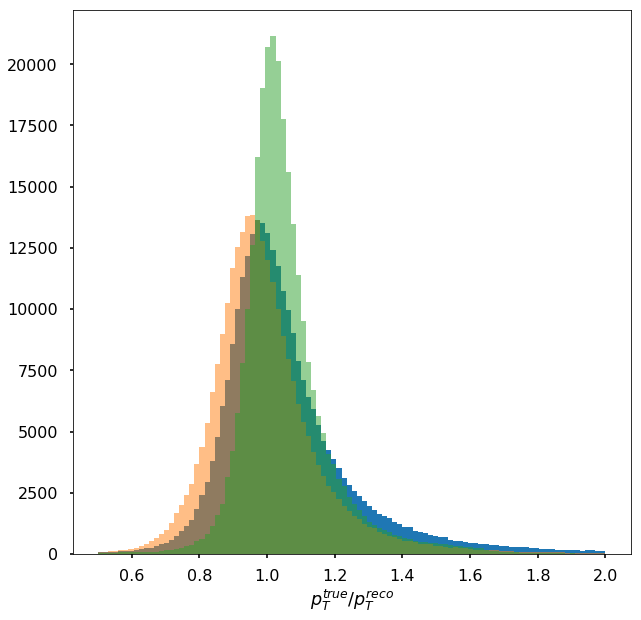

In [6]:
me = err.mean()
std = err.std()
mse = np.square(err).mean()
mae = np.abs(err).mean()
print('test me ', me, ' std ', std, ' norm std ', std/config['y_std'], ' norm mse ', mse/config['y_std']**2, ' norm mae ', mae / config['y_std'])



_,bins,_ = plt.hist(y[:,0],bins=100,range=[0.5,2],label='target');
plt.hist(y_hbb[:,0],bins=bins,alpha=0.5,label='HIG-17-009');
plt.hist(y_pred[:,0],bins=bins,alpha=0.5,label='prediction');
plt.xlabel('$p_T^{true} / p_T^{reco}$')
plt.legend(True)
plt.savefig('/users/nchernya//HHbbgg_ETH/bregression/plots/HybridLoss/Pasquale_pT_true_reco_Hig_17_009.pdf')

In [18]:
import sys
sys.path.insert(0, '/users/nchernya/HHbbgg_ETH/bregression/python/')
import plotting_utils

Welcome to JupyROOT 6.10/02


ImportError: cannot import name 'RooRealVar'